In [ ]:
%%shell

# download the train dataset
#wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip 
#wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/test_set.zip
unzip drive/MyDrive/LaneData/train_set.zip &> /dev/null
unzip drive/MyDrive/LaneData/test_set.zip &> /dev/null

In [ ]:
%%shell
pip install cython &> /dev/null
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' &> /dev/null

In [3]:
# Library imports
from PIL import Image
import time, math, cv2, imutils, os, json, random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [4]:
TRAIN_DIR = Path.cwd().parent.joinpath('content/train_set')
TEST_DIR = Path.cwd().parent.joinpath('content/test_set')

In [48]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all labels
        label_files = [f for f in self.root.glob('*.json')]
        json_gt = []
        for label_file in label_files:
            json_gt.extend([json.loads(line) for line in open(self.root.joinpath(label_file))])
        self.json_gt = json_gt

    def __getitem__(self, idx):
        # load images ad masks
        gt = self.json_gt[idx]
        gt_lanes = gt['lanes']
        y_samples = gt['h_samples']
        img_path = self.root.joinpath(gt['raw_file'])
        img = Image.open(img_path).convert("RGB")
        #Make Ground Truth Image mask
        gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
        #height, width = np.array(img).shape
        mask = np.zeros(np.array(img).shape[0:2])
        for lane in gt_lanes_vis:
            cv2.polylines(mask, np.int32([lane]), isClosed=False, color=(1.0), thickness=5)
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        target = {}

        if num_objs:
          boxes = []
          for i in range(num_objs):
              pos = np.where(masks[i])
              xmin = np.min(pos[1])
              xmax = np.max(pos[1])
              ymin = np.min(pos[0])
              ymax = np.max(pos[0])
              boxes.append([xmin, ymin, xmax, ymax])

          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          # there is only one class
          labels = torch.ones((num_objs,), dtype=torch.int64)
          masks = torch.as_tensor(masks, dtype=torch.uint8)

          image_id = torch.tensor([idx])
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
          # suppose all instances are not crowd
          iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

          
          target["boxes"] = boxes
          target["labels"] = labels
          target["masks"] = masks
          target["image_id"] = image_id
          target["area"] = area
          target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.json_gt)

In [7]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../ &> /dev/null
cp references/detection/transforms.py ../ &> /dev/null
cp references/detection/coco_eval.py ../ &> /dev/null
cp references/detection/engine.py ../ &> /dev/null
cp references/detection/coco_utils.py ../ &> /dev/null

In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
# use our dataset and defined transformations
dataset_train = LaneDataset(TRAIN_DIR, get_transform(train=True))
dataset_valid = LaneDataset(TRAIN_DIR, get_transform(train=False))

# split the dataset in train and validation sets
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()
TRAIN_SIZE = int(0.8*len(indices))
dataset_train = torch.utils.data.Subset(dataset_train, indices[:TRAIN_SIZE])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[TRAIN_SIZE:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
   dataset_valid, batch_size=1, shuffle=False, num_workers=4,
   collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and lane
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [12]:
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [   0/1450]  eta: 0:51:12  lr: 0.000010  loss: 6.3297 (6.3297)  loss_classifier: 0.5796 (0.5796)  loss_box_reg: 0.0991 (0.0991)  loss_mask: 5.5306 (5.5306)  loss_objectness: 0.1010 (0.1010)  loss_rpn_box_reg: 0.0193 (0.0193)  time: 2.1190  data: 1.0923  max mem: 2504
Epoch: [0]  [  50/1450]  eta: 0:14:21  lr: 0.000260  loss: 0.4265 (1.1741)  loss_classifier: 0.0669 (0.2137)  loss_box_reg: 0.0765 (0.0782)  loss_mask: 0.1985 (0.7943)  loss_objectness: 0.0309 (0.0648)  loss_rpn_box_reg: 0.0169 (0.0230)  time: 0.5905  data: 0.0110  max mem: 2775
Epoch: [0]  [ 100/1450]  eta: 0:13:46  lr: 0.000509  loss: 0.2463 (0.7279)  loss_classifier: 0.0382 (0.1314)  loss_box_reg: 0.0736 (0.0781)  loss_mask: 0.1095 (0.4592)  loss_objectness: 0.0171 (0.0425)  loss_rpn_box_reg: 0.0089 (0.0167)  time: 0.6154  data: 0.0110  max mem: 2775
Epoch: [0]  [ 150/1450]  eta: 0:13:27  lr: 0.000759  loss: 0.2143 (0.5621)  loss_classifier: 0.0279 (0.0982)  loss_box_reg: 0.0688 (0.0771)  loss_mask: 0.0996 (

# Inference

In [ ]:
dataset_test = LaneDataset(TEST_DIR, get_transform(train=False))

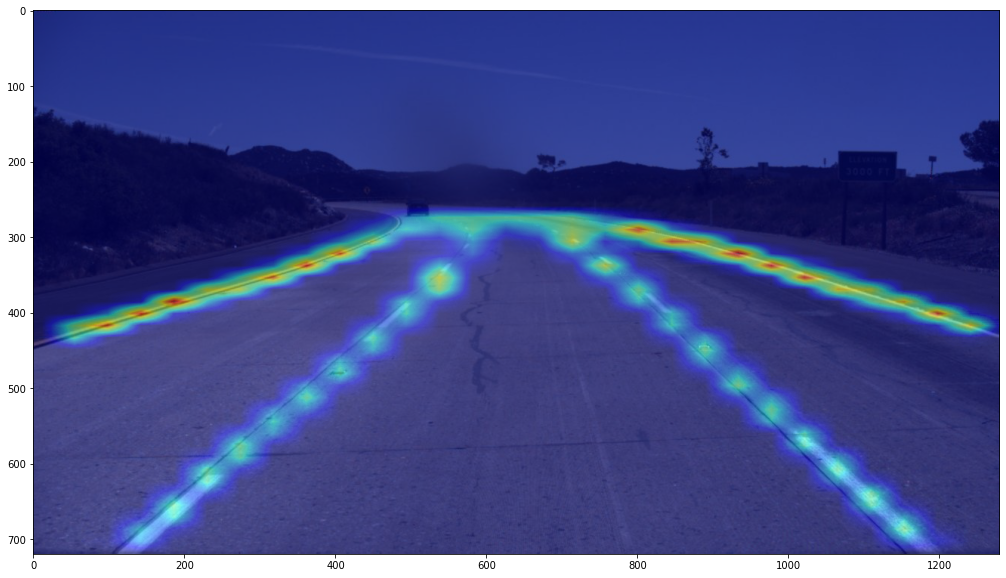

In [57]:
idx = 1
# pick one image from the test set
img, _ = dataset_test[idx]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
mask = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.show()

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
count_parameters(model)

43699995

In [28]:
torch.save(model, 'drive/MyDrive/laneDetectionModel.pkl')

In [ ]:
while True:pass